<a href="https://colab.research.google.com/github/madhugopinathan/deep-nlu/blob/master/yelp_reviews_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Yelp Reviews EDA

In [1]:
!wget https://s3.amazonaws.com/fast-ai-nlp/yelp_review_full_csv.tgz

--2019-08-18 12:05:01--  https://s3.amazonaws.com/fast-ai-nlp/yelp_review_full_csv.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.139.141
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.139.141|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 196146755 (187M) [application/x-tar]
Saving to: ‘yelp_review_full_csv.tgz’

yelp_review_full_cs 100%[===================>] 187.06M  45.3MB/s    in 4.5s    

2019-08-18 12:05:05 (41.6 MB/s) - ‘yelp_review_full_csv.tgz’ saved [196146755/196146755]



In [2]:
!tar xvfz yelp_review_full_csv.tgz

yelp_review_full_csv/
yelp_review_full_csv/train.csv
yelp_review_full_csv/readme.txt
yelp_review_full_csv/test.csv


In [0]:
%config InlineBackend.figure_format = 'retina'

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import svds

In [0]:
import pandas as pd

In [0]:
pd.options.display.max_colwidth=-1

In [0]:
import seaborn as sns

In [0]:
import spacy

In [0]:
nlp = spacy.load('en')

## Load Reviews: Browse Restaurant Reviews


In [0]:
DATA_DIR = "./yelp_review_full_csv/"

In [0]:
df = pd.read_csv(DATA_DIR + "train.csv", header=None, names=['rating', 'review'])

In [15]:
df[df.review.str.contains("indian")].sample(3)

,rating,review
144061,3,Service is decent. Food is ok. Definitely not best indian food I have had. Good for them they are in vegas where other indian restaurants are pretty bad as well.
472178,3,"We made an unplanned stop for a late dinner on the way home around a little bit after 8pm. We were immediately seated along the wall with some free Pappar (crunchy tortilla like chips) and water.\n\nBesides indian dish, they had some indo-chinese dishes on the menu which I personally did not care for. We ordered the Lamb Kadai and a chicken Biryani along with some naan. The Lamb Kadai was good but the chicken Biryani wasn't quite what we expected. It wasn't bad - Let's just say, I've had better at other places. Also, the server forgot to bring the yogurt thing that usually comes with the Biryani. However, another server brought us that mid way through our meal. \n\nOverall, a decent visit. I would definitely give another shot. Besides that minor hiccup with the yogurt thing - the service overall was pretty good."
136492,5,"Last night in Vegas:\n\nMy girlfriend and I wanted to eat somewhere off the strip and have some good Indian food. We are both glad we found this place. Ok it may not be in the best part of town, but the food more than makes up for it.\n\nAppetizers: Complimentary flat breads with dipping sauces\n\nEntrees: Lamb Curry & Chicken Tikka Masala\n\nSides: Keemon Naan and Plain Naan.\n\nEverything was oh so good. I don't really eat too much indian food, maybe because I'm worried that I'm going to get bad indian food. But I'm glad we went here. First thing you notice when you walk in, is that everyone that is sitting in the restaurant is indian! Ok, so they're all indian this place must be good! And YES it was. For sure we are going to have to go back here again if and when we are in Vegas..."


## Extract cuisines using Spacy Named Entity Recognition (NER)



*   GPE: Geo-political entity
*   NORP: Nationalities, religious, political groups



In [0]:
text = """Definitely not the best Indian food I have had. 
          Good for them they are in Vegas where other Indian restaurants 
          are pretty bad as well."""

In [18]:
doc = nlp(text)
for ent in doc.ents:
    print(ent.label_, ent.lower_, ent.start, ent.end)

NORP indian 4 5
GPE vegas 17 18
NORP indian 20 21


In [21]:
doc[4:5], doc[17:18]

(Indian, Vegas)

### Build a cuisine - word co-occurrence matrix



*   cuisine2idx: map cuisine to index

    * idx2cuisine: map index to cuisine
    
*   token2idx: map other tokens to indices

    * idx2token: map index to token



In [0]:
def get_cuisine_idx(cuisine):
    return cuisine2idx.setdefault(cuisine, len(cuisine2idx))

def get_token_idx(token):
    return token2idx.setdefault(token, len(token2idx))

In [0]:
def build_cuisine_token_mat(df,ws=10):
    row = []
    col = []
    data = []
    
    def do_count_tokens(cuisine, tokens):
        for tok in tokens:
            if len(tok.ent_type_) > 0 or tok.is_stop or tok.is_punct:
                continue
            row.append(get_cuisine_idx(cuisine.lower_))
            col.append(get_token_idx(tok.lower_))
            data.append(1.)
    
    for doc in nlp.pipe(df.review):
        for ent in doc.ents:
            # NORP: nationalities, religious, political groups
            if ent.label_ == "NORP": 
                # count left side window
                do_count_tokens(ent, doc[ent.start-ws:ent.start]) 
                # count right side window
                do_count_tokens(ent, doc[ent.end:ent.end+ws])
    
    return sparse.csr_matrix((data, (row, col)), 
                             shape=(len(cuisine2idx), len(token2idx)))

In [26]:
%%time
cuisine2idx = {}
token2idx = {}
small_df = df.sample(20000)
cuisine_token_mat = build_cuisine_token_mat(small_df)

CPU times: user 5min 51s, sys: 7.39 s, total: 5min 59s
Wall time: 5min 59s


In [0]:
idx2token = {v:k for k,v in token2idx.items()}
idx2cuisine = {v:k for k,v in cuisine2idx.items()}

In [0]:
def get_top_cuisine_indices(mat,n):
    rowsum = np.squeeze(np.asarray(mat.sum(axis=1)))
    return np.argsort(rowsum)[::-1][:n]

In [30]:
for idx in get_top_cuisine_indices(cuisine_token_mat,20):
    print(idx,idx2cuisine[idx])

3 mexican
14 italian
6 chinese
8 thai
7 asian
31 french
11 japanese
30 american
27 indian
1 korean
81 vietnamese
88 greek
16 venetian
13 hawaiian
17 irish
49 cheese
4 spanish
106 cuban
68 brazilian
0 mongolian


In [0]:
def get_top_token_indices(mat,n):
    rowsum = np.squeeze(np.asarray(mat.sum(axis=0)))
    return np.argsort(rowsum)[::-1][:n]

In [33]:
for idx in get_top_token_indices(cuisine_token_mat,20):
    print(idx,idx2token[idx])

8  
57 food
6 good
98 place
185 like
54 restaurant
156 great
157 ordered
260 menu
43 restaurants
171 best
9 chicken
0 service
72 better
137 time
705 try
354 got
82 pretty
286 salad
271 $


### How sparse is the matrix?

In [35]:
cuisine_token_mat.shape

(830, 7047)

In [36]:
cuisine_token_mat.nnz

22388

In [38]:
cuisine_token_mat.nnz/np.prod(cuisine_token_mat.shape) * 100

0.3827656304229263

### Visualize top cuisines x top tokens

In [0]:
def get_cuisine_token_df(mat,n=25):
    cuisine_indices = get_top_cuisine_indices(mat, n)
    token_indices = get_top_token_indices(mat, n)

    data = []
    co_mat = np.zeros((len(cuisine_indices), len(token_indices)))
    for i,cidx in zip(range(n),cuisine_indices):
        for j, jidx in zip(range(n),token_indices):
            data.append((idx2cuisine[cidx], idx2token[jidx], 
                         cuisine_token_mat[cidx, jidx]))
            
    columns=['cuisine','token','freq']
    df = pd.DataFrame(data,columns=columns)
    return df.pivot(*columns)

In [0]:
ct_df = get_cuisine_token_df(cuisine_token_mat)

In [47]:
ct_df.head()

token,,$,best,better,cheese,chicken,dishes,food,good,got,great,like,little,love,menu,ordered,place,places,pretty,restaurant,restaurants,salad,service,time,try
cuisine,,,,,,,,,,,,,,,,,,,,,,,,,
american,39.0,3.0,3.0,2.0,9.0,5.0,2.0,22.0,11.0,6.0,7.0,18.0,0.0,0.0,12.0,6.0,11.0,1.0,5.0,9.0,0.0,6.0,5.0,3.0,4.0
asian,73.0,3.0,3.0,11.0,0.0,5.0,10.0,62.0,31.0,4.0,9.0,20.0,7.0,6.0,7.0,3.0,34.0,3.0,8.0,17.0,10.0,7.0,9.0,3.0,8.0
brazilian,5.0,0.0,2.0,0.0,0.0,0.0,1.0,3.0,4.0,2.0,2.0,5.0,3.0,0.0,0.0,0.0,4.0,0.0,2.0,2.0,0.0,4.0,2.0,1.0,1.0
cheese,27.0,2.0,3.0,1.0,7.0,1.0,0.0,1.0,9.0,1.0,4.0,5.0,0.0,1.0,0.0,2.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
chinese,97.0,4.0,12.0,17.0,2.0,19.0,12.0,168.0,61.0,6.0,22.0,35.0,15.0,10.0,28.0,4.0,45.0,15.0,12.0,56.0,24.0,1.0,14.0,7.0,10.0


In [0]:
ct_df.drop(columns=[' ','$','food'], inplace=True)

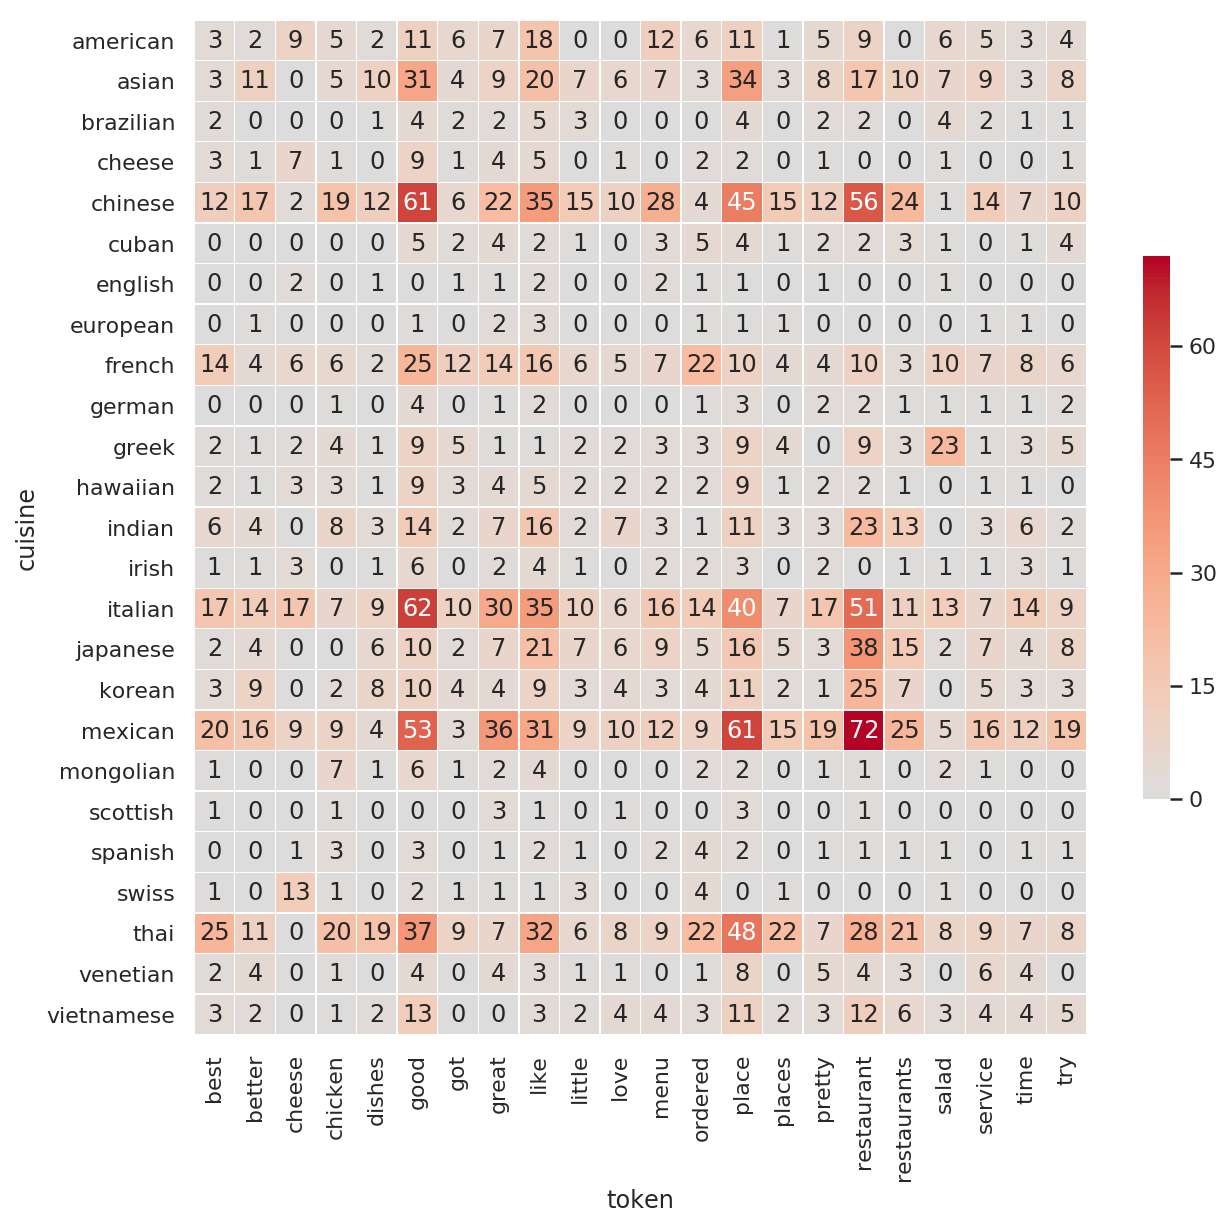

In [49]:
fig = plt.figure(figsize=(10, 10))  
sns.set(style='white')  
ax = sns.heatmap(ct_df, 
                 cmap="coolwarm",
                 annot=True, 
                 center=0, square=True, 
                 linewidths=0.2,cbar_kws={"shrink": 0.5})

## Build cuisine / token vectors using PPMI + SVD


[Positive Pointwise Mutual Information](https://web.stanford.edu/~jurafsky/slp3/6.pdf)

*   See section 6.7
    
Pointwise mutual information is one of the most important concepts in NLP. It is a measure of how often two events x and y occur, compared with
what we would expect if they were independent.

\begin{align}
\text{PMI(w,c)} = \text{log}_2\frac{P(w,c)}{P(w)P(c)}
\end{align}



In [0]:
def pmi(xy, x, y, N):
    """
    Point-wise mutual information score of two events x, y
    N is the sample size of the universe.
    """
    return np.log2(xy) + np.log2(N) - np.log2(x) - np.log2(y)

        
def ppmi(xy, x, y, N, pmi_threshold):
    val = pmi(xy, x, y, N)
    return 0 if val < pmi_threshold else val


def build_ppmi_mat(csr_mat, count_threshold, pmi_threshold):
    below_threshold = np.sum(csr_mat.data < count_threshold)
    total = csr_mat.nnz
    print(f"Pct. of elements below count_threshold {below_threshold/total} / total {total}")

    csr_mat = csr_mat.copy()
    csr_mat.data[csr_mat.data < count_threshold] = 0
    csr_mat.eliminate_zeros()

    print(f"Number of elements after zeroing out data: {csr_mat.nnz}")

    coo = csr_mat.tocoo()
    rowsum = np.squeeze(np.asarray(coo.sum(axis=1)))
    colsum = np.squeeze(np.asarray(coo.sum(axis=0)))
    N = coo.sum()


    data = [ppmi(count, rowsum[r], colsum[c], N, pmi_threshold) 
            for r,c,count in zip(coo.row, coo.col, coo.data)]
    ppmi_csr = sparse.csr_matrix((data, (coo.row, coo.col)), shape=coo.shape)
    ppmi_csr.eliminate_zeros()
    return ppmi_csr

In [51]:
ppmi_mat = build_ppmi_mat(cuisine_token_mat, 3, 0.05)

Pct. of elements below count_threshold 0.9176791138109701 / total 22388
Number of elements after zeroing out data: 1843


In [0]:
U,S,VT = svds(ppmi_mat, k=30)

In [0]:
word_vectors = np.vstack((U,VT.T))

In [0]:
norm = np.linalg.norm(word_vectors,axis=1,keepdims=True)
norm_word_vectors = np.divide(word_vectors,norm,out=np.zeros_like(word_vectors), 
                              where=norm!=0)

In [0]:
def show_nearest_neighbours(word, is_cuisine=True, n=10):
  if is_cuisine:
    idx = cuisine2idx[word]
  else:
    idx = token2idx[word]
    
  vec = norm_word_vectors[idx]
  for oidx in np.argsort(norm_word_vectors.dot(vec))[::-1][:n]:
    if oidx < len(idx2cuisine):
        print(idx2cuisine[oidx])
    else:
        print(idx2token[oidx-len(idx2cuisine)])

In [60]:
show_nearest_neighbours('mexican')

mexican
felt
free
quesadilla
calling
\nwe
return
u
walking
shredded


In [61]:
show_nearest_neighbours('indian')

indian
samosas
spices
tikka
recommended
naan
expecting
bland
eaten
especially


In [62]:
show_nearest_neighbours('english')

english
muffin
fruit
muffins
instead
egg
bacon
panini
und
 


In [63]:
show_nearest_neighbours('italian')

italian
peppers
deli
idea
cold
ham
sub
included
door
chose


In [76]:
show_nearest_neighbours('japanese')

japanese
chefs
mackarel
believe
sign
use
difference
miso
wasabi
finally


# [Vector Semantics](https://web.stanford.edu/~jurafsky/slp3/6.pdf)

Words that occur in similar contexts tend to have similar
meanings. This link between similarity in how words are distributed and similarity
in what they mean is called the **distributional hypothesis**. The hypothesis was first formulated in the 1950s by linguists like Joos (1950), Harris (1954), and Firth (1957), who noticed that words which are synonyms (like oculist and eye-doctor) tended to occur in the same environment (e.g., near words like eye or examined) with the amount of meaning difference between two words “corresponding roughly to the amount of difference in their environments”

A **vector semantics model** instantiates this linguistic hypothesis by learning representations of the meaning of words directly from their distributions in texts. These representations are used in every natural language processing application that makes use of meaning. 

An important focus of recent NLP research is **representation learning**, i.e. unsupervised methods to learn vector representations of the input, instead of creating representations manually by feature engineering.